In [1]:
!pip install torchsummary

In [2]:
# Importing all important libraries
import os                       # for working with files
import numpy as np              # for numerical computationss
import pandas as pd             # for working with dataframes
import seaborn as sns           # for working with maps
import torch                    # Pytorch module
import matplotlib.pyplot as plt # for plotting informations on graph and images using tensors
import torch.nn as nn           # for creating  neural networks
from torch.utils.data import DataLoader # for dataloaders
from PIL import Image           # for checking images
import torch.nn.functional as F # for functions for calculating loss
import torchvision.transforms as transforms   # for transforming images into tensors
from torchvision.utils import make_grid       # for data checking
from torchvision.datasets import ImageFolder  # for working with classes and images
from torchsummary import summary              # for getting the summary of our model
import tensorflow as ts
from  tensorflow import keras
import itertools
from sklearn.metrics import precision_score, accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve

%matplotlib inline

In [3]:
pip install tensorflow opencv-python matplotlib scikit-learn


In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [5]:
!pip install kaggle

In [8]:
import json

kaggle_credentails = json.load(open("kaggle.json"))

In [9]:
# setup Kaggle API key as environment variables
os.environ['KAGGLE_USERNAME'] = kaggle_credentails["username"]
os.environ['KAGGLE_KEY'] = kaggle_credentails["key"]

In [10]:
!kaggle datasets download -d vipoooool/new-plant-diseases-dataset

Dataset URL: https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset
License(s): copyright-authors


In [11]:
!ls

kaggle.json  new-plant-diseases-dataset.zip  sample_data


In [12]:
# Import the ZipFile class from the zipfile module
from zipfile import ZipFile

# Unzip the downloaded dataset
with ZipFile("new-plant-diseases-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall()

In [13]:
# Dataset
dataset="/content/New Plant Diseases Dataset(Augmented)"
# Training Data
train_data="/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train"
# Validation Data
valid_data="/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid"
# Testing Data
test_data="/content/test/test"

In [14]:
# Step 3: Preprocess the data
img_height, img_width = 128, 128
batch_size = 32
num_classes = 38  # Adjust based on dataset (38 classes in New Plant Diseases Dataset)
sequence_length = 5  # Number of images in a sequence for LSTM

In [15]:
# Create data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)


In [16]:
# Load training and validation data
train_generator = train_datagen.flow_from_directory(
    train_data,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

valid_generator = valid_datagen.flow_from_directory(
    valid_data,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


In [17]:
# Function to create sequences for LSTM
def create_sequences(generator, sequence_length):
    X, y = [], []
    for _ in range(1000):  # Adjust based on dataset size
        batch_x, batch_y = next(generator)
        for i in range(len(batch_x) - sequence_length):
            X.append(batch_x[i:i+sequence_length])
            y.append(batch_y[i+sequence_length-1])
    return np.array(X), np.array(y)

In [18]:
# prompt: create a sequences that take less time to run reduce the sample size

def create_sequences(generator, sequence_length, sample_size=1000):
    X, y = [], []
    samples_processed = 0
    while samples_processed < sample_size:
        try:
            batch_x, batch_y = next(generator)
            for i in range(len(batch_x) - sequence_length):
                X.append(batch_x[i:i+sequence_length])
                y.append(batch_y[i+sequence_length-1])
                samples_processed += 1
                if samples_processed >= sample_size:
                    break
        except StopIteration:
            print("Reached end of generator. Resetting generator.")
            generator.reset() # Reset the generator if it reaches the end

    return np.array(X), np.array(y)


In [19]:
# Step 4: Build the LSTM model
from tensorflow.keras.layers import TimeDistributed, LSTM # Import LSTM

model = Sequential([
    # TimeDistributed CNN for feature extraction
    TimeDistributed(Conv2D(32, (3, 3), activation='relu'), input_shape=(sequence_length, img_height, img_width, 3)),
    TimeDistributed(MaxPooling2D((2, 2))),
    TimeDistributed(Conv2D(64, (3, 3), activation='relu')),
    TimeDistributed(MaxPooling2D((2, 2))),
    TimeDistributed(Flatten()),
    # LSTM layer
    LSTM(128, return_sequences=False), # Now LSTM is recognized
    # Dense layers
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

In [20]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 5, 126, 126,    │           896 │
│ (TimeDistributed)               │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 5, 63, 63, 32)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 5, 61, 61, 64)  │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 5, 30, 30, 64)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 5, 57600)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │    29,557,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 38)             │         4,902 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,598,054 (112.91 MB)

 Trainable params: 29,598,054 (112.91 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Step 5: Train the model
# Call create_sequences to generate training and validation data
X_train, y_train = create_sequences(train_generator, sequence_length, sample_size=1000)  # Adjust sample_size as needed
X_valid, y_valid = create_sequences(valid_generator, sequence_length, sample_size=1000)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=10,
    batch_size=batch_size
)


Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 309ms/step - accuracy: 0.0366 - loss: 3.7222 - val_accuracy: 0.0610 - val_loss: 3.5751
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 233ms/step - accuracy: 0.0444 - loss: 3.6291 - val_accuracy: 0.0290 - val_loss: 3.4390
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 233ms/step - accuracy: 0.0538 - loss: 3.5492 - val_accuracy: 0.3740 - val_loss: 3.2099
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 200ms/step - accuracy: 0.0837 - loss: 3.4672 - val_accuracy: 0.3450 - val_loss: 3.1109
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 203ms/step - accuracy: 0.1402 - loss: 3.2522 - val_accuracy: 0.3680 - val_loss: 2.9447
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 201ms/step - accuracy: 0.2015 - loss: 2.9666 - val_accuracy: 0.1600 - val_loss: 3.0682
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 202ms/step - accuracy: 0.3352 - loss: 2.5800 - val_accuracy: 0.2830 - val_loss: 2.8915
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 236ms/step - accuracy: 0.4946 - loss: 2.0536 - val_accurac

Enter the full path of the image: /content/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/train/Apple___Black_rot/0090d05d-d797-4c99-abd4-3b9cb323a5fd___JR_FrgE.S 8727.JPG
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


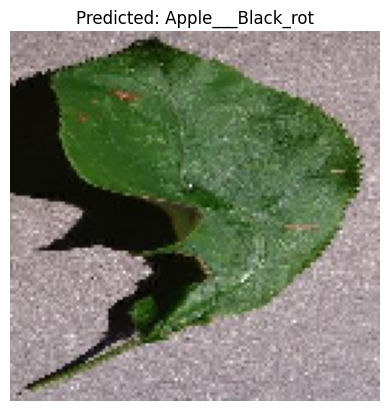

'Apple___Black_rot'

In [22]:
from tensorflow.keras.preprocessing import image # Import image module

def predict_image(img_path, sequence_length=5): # Added sequence_length
    # Load the image
    img = image.load_img(img_path, target_size=(128,128))  # same size as during training
    img_array = image.img_to_array(img)

    # Repeat the image to create a sequence
    img_array = np.repeat(np.expand_dims(img_array, axis=0), sequence_length, axis=0)

    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize (same as training)

    # Predict
    predictions = model.predict(img_array)
    # Assuming Li is a variable containing class names
    # If Li is not defined, replace it with the actual class names
    class_names = train_generator.class_indices  # Get class names from the generator
    class_names = list(class_names.keys())

    predicted_class = class_names[np.argmax(predictions)]

    # Plot the image with prediction
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class}")
    plt.axis('off')
    plt.show()

    return predicted_class
img_path = input("Enter the full path of the image: ")
predict_image(img_path) # Call with img_path